# <span style='color:blue'> Importando os pacotes necessarios</span>

In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Checando a tabela verdade

### Esta tabela contem os dados que serao nosso y_train

In [ ]:
truth_table = pd.read_csv('DATA/train.truth.csv')

In [3]:
truth_table.head()

,fn,label
0,0-10049200_1891-09-16_1958.jpg,rotated_left
1,0-10110600_1985-09-17_2012.jpg,rotated_left
2,0-10126400_1964-07-07_2010.jpg,upright
3,0-1013900_1917-10-15_1960.jpg,rotated_right
4,0-10166400_1960-03-12_2008.jpg,upside_down


In [4]:
truth_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48896 entries, 0 to 48895
Data columns (total 2 columns):
fn       48896 non-null object
label    48896 non-null object
dtypes: object(2)
memory usage: 764.1+ KB


## Separando as colunas, poderiamos ter usado o pandas, mas vamos aprender outra forma

In [5]:
from numpy import genfromtxt
y_train = np.array(truth_table)

In [278]:
file_names = list(truth_table['fn'].values)
img_label = list(truth_table['label'].values)

### Verificando se o y_train tem o mesmo tamanho do diretorio que vamos usar para treinar(x_test)

In [277]:
y_train.shape

(48896, 2)

## Verificando uma imagem do diretorio para ver se esta lendo corretamente

In [9]:
img_test = cv2.imread('DATA/train/0-10110600_1985-09-17_2012.jpg')

In [275]:
img_test.shape

(64, 64, 3)

In [281]:
img_test = cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB)

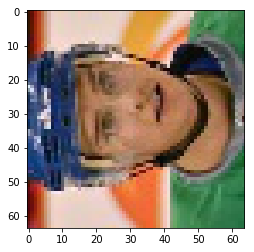

In [283]:
plt.imshow(img_test)

### Verificando quantas classes temos dentro de y_test

In [11]:
truth_table['label'].value_counts()

rotated_right    12314
rotated_left     12266
upright          12212
upside_down      12104
Name: label, dtype: int64

In [12]:
# Imports necessarios para manipulacao das pastas no Windowns
import os
import shutil

In [61]:
folders= np.unique(list(truth_table['label'].values))

In [62]:
folders

array(['rotated_left', 'rotated_right', 'upright', 'upside_down'],
      dtype='<U13')

### Criando as pastas para receber os arquivos de cada classe

In [111]:
for new_path in folders:
    if not os.path.exists('DATA/train/{}'.format(new_path)):
        os.makedirs(new_path)
        shutil.move('c:/Users/user/NN_Rotate/{}'.format(new_path),'DATA/train')       

### Enviando as imagens para cada pastas separada

In [113]:
for f in range(len(truth_table)):
    current_img= file_names[f]
    current_label = img_label[f]
    shutil.move('c:/Users/user/NN_Rotate/DATA/train/{}'.format(current_img),'DATA/train/{}'.format(current_label))

In [16]:
input_shape = (64,64,3)

In [17]:
## Pre processamento de imagens do keras, facilitando a vida da nossa rede neural 
from keras.preprocessing.image import ImageDataGenerator


In [284]:
img_gen = ImageDataGenerator(featurewise_center=True,
                            width_shift_range=0.2,
                            rescale=1./255,
                            height_shift_range=0.2,
                            fill_mode='nearest')

### Identificando as classes 

In [40]:
train_img_gen = img_gen.flow_from_directory('DATA/train',
                                   class_mode='categorical',
                                   batch_size=16,
                                   target_size=input_shape[:2])

Found 48896 images belonging to 4 classes.


#### Infelizmente como nao estava em categoria o y_test nao deu para adicionar a CNN

In [41]:
test_img_gen = img_gen.flow_from_directory('DATA/test',
                                   class_mode='categorical',
                                   batch_size=16,
                                   target_size=input_shape[:2])

Found 0 images belonging to 0 classes.


In [86]:
# Verificando as classes
train_img_gen.class_indices

{'rotated_left': 0, 'rotated_right': 1, 'upright': 2, 'upside_down': 3}

In [43]:
# Imports necessarios para a CNN
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### Criando a Cnn e defindo as layers e neuronios

In [45]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))


model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [46]:
# Resumdo da CNN
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
__________

In [47]:
# treinando a CNN
results = model.fit_generator(train_img_gen,
                              epochs=30,
                              steps_per_epoch=150,
                              validation_steps=12)

Epoch 1/30


C:\Users\user\Anaconda3\envs\python-cvcourse\lib\site-packages\keras_preprocessing\image.py:988: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


150/150 [==============================] - 22s 150ms/step - loss: 0.5643 - acc: 0.7496
Epoch 2/30
150/150 [==============================] - 21s 141ms/step - loss: 0.5589 - acc: 0.7502
Epoch 3/30
150/150 [==============================] - 21s 141ms/step - loss: 0.5439 - acc: 0.7499
Epoch 4/30
150/150 [==============================] - 21s 143ms/step - loss: 0.5081 - acc: 0.7628
Epoch 5/30
150/150 [==============================] - 21s 143ms/step - loss: 0.4626 - acc: 0.7955
Epoch 6/30
150/150 [==============================] - 21s 142ms/step - loss: 0.4477 - acc: 0.7979
Epoch 7/30
150/150 [==============================] - 21s 142ms/step - loss: 0.4181 - acc: 0.8161
Epoch 8/30
150/150 [==============================] - 21s 143ms/step - loss: 0.3903 - acc: 0.8289
Epoch 9/30
150/150 [==============================] - 22s 144ms/step - loss: 0.3669 - acc: 0.8451
Epoch 10/30
150/150 [==============================] - 21s 142ms/step - loss: 0.3508 - acc: 0.8540
Epoch 11/30
150/150 [=========

In [29]:
results.history['acc']

[0.8339583333333334,
 0.8498958333333333,
 0.8517708333333334,
 0.8554166666666667,
 0.8557291666666667,
 0.8760416666666667,
 0.87,
 0.8730208333333334,
 0.8815625,
 0.8784375,
 0.8805208333333333,
 0.8857291666666667,
 0.8938541666666666,
 0.8954166666666666,
 0.8916666666666667,
 0.9007291666666667,
 0.8998958333333333,
 0.8980208333333334,
 0.8997916666666667,
 0.9029166666666667,
 0.9085416666666667,
 0.9075,
 0.9108333333333334,
 0.9121875,
 0.9151041666666667,
 0.9095833333333333,
 0.915625,
 0.91,
 0.9192708333333334,
 0.9153125]

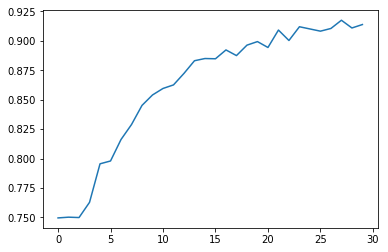

In [48]:
# Percebemos que depois do 25 epoch a rede praticamente chega a seu plato
plt.plot(results.history['acc'])

In [31]:
# Salvando o modelo, vai que da problema
model.save('CNN_teste.h5')

# Hora de rodar os testes, para isso vamos pre-processara as imagens da pasta teste

In [54]:
from keras.preprocessing import image
import PIL

#### Buscando as imagens e tranformando em arrays no formato para nossa CNN ler

In [73]:
path = 'c:/Users/user/NN_Rotate/DATA/test'
images = []
for img in os.listdir(path):
    img = 'c:/Users/user/NN_Rotate/DATA/test/{}'.format(img)
    img = image.load_img(img, target_size=(64,64))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = img/255
    images.append(img)

#### Criando o arquivo com a predicao

In [77]:
images= np.vstack(images)
classes=model.predict_classes(images)

In [289]:
# Checando tamanho para poder fazer o looping
len(images) == len(classes)

True

In [290]:
classes[0:10]

array([0, 2, 1, 1, 1, 1, 0, 0, 3, 2], dtype=int64)

In [88]:
Checando as classes para garantir
train_img_gen.class_indices

{'rotated_left': 0, 'rotated_right': 1, 'upright': 2, 'upside_down': 3}

## Decobrindo a melhor forma de rotacionar

In [269]:
img_test = cv2.imread('DATA/train/rotated_left/0-10110600_1985-09-17_2012.jpg')

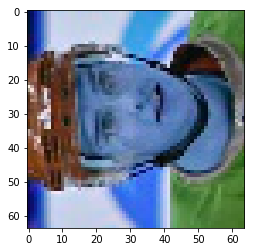

In [270]:
plt.imshow(img_test)

In [265]:
rotate = cv2.flip(img_test,-1)

In [177]:
rotate2 =rotateImage(img_test,180)

In [271]:
rotate2 = cv2.transpose(img_test)

In [250]:
rotate2 = cv2.flip(rotate2,0)

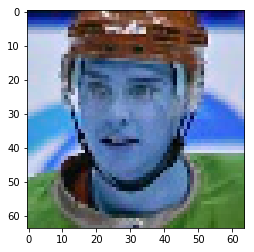

In [272]:
plt.imshow(rotate2)

In [97]:
cv2.imwrite('DATA/TESTE.jpeg',rotate1)

True

# Rotacionando as imagens e colocando as mesmas na pasta

In [294]:
label = []
fn = []

for i,file in enumerate(os.listdir(path)):
    
    img = cv2.imread('c:/Users/user/NN_Rotate/DATA/test/{}'.format(file))
    
    if classes[i] == 1:
        trans =cv2.transpose(img)
        img = cv2.flip(trans,0)
        lab = 'rotated_right'
    
    if classes[i] == 3:
        img = cv2.flip(img,0)
        lab = 'upside_down'
    
    if classes[i] == 0:
        img = cv2.transpose(img)
        lab = 'rotated_left'
    
    else:
        lab = 'upright'
    #saving now
    cv2.imwrite('DATA/result/{}'.format(file), img)
    fn.append(file)
    label.append(lab)

In [292]:
train_img_gen.class_indices

{'rotated_left': 0, 'rotated_right': 1, 'upright': 2, 'upside_down': 3}

In [307]:
# Criando o dataframe de testes

In [296]:
len(label)

5361

In [298]:
len(fn)

5361

In [302]:
df = pd.DataFrame({'fn':fn,'label':label})

In [303]:
df.head()

,fn,label
0,90-10184590_1979-06-16_2006.jpg,rotated_left
1,90-1019890_1931-08-10_1978.jpg,upright
2,90-10241990_1984-11-28_2007.jpg,upright
3,90-102690_1966-09-09_2011.jpg,upright
4,90-10303590_1983-01-26_2010.jpg,upright


In [306]:
df.to_csv('test.preds.csv')